# Stock Prediction
Predicting stock market price of an indicator.

# 1. <b>Preprocessing</b>

# 1. Configuration

In [1]:
import sys
import os

sys.path.append("\\".join(os.path.abspath(os.path.pardir).split("\\")[:-1]))

In [2]:
from utils.ml.window import WindowGenerator
from utils.ml.compile import compile_and_fit
from utils.ml.globals import DAYS_TO_LEARN

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from mpl_toolkits.axes_grid1 import make_axes_locatable

from datetime import datetime

mpl.rcParams["figure.figsize"] = (10, 5)
mpl.rcParams["axes.grid"] = False

# 2. Data Importing

In [3]:
path_data = "../../data/train/raw/polygon/"
df = pd.read_csv(path_data+"ORCL_Yahoo.csv", skiprows=[1, 2])
print(df.shape)
df.head()

(9834, 6)


,Price,Close,High,Low,Open,Volume
0,1986-03-12,0.051101,0.051724,0.051101,0.051101,393012000
1,1986-03-13,0.052347,0.052970,0.052347,0.052347,125290800
2,1986-03-14,0.054217,0.054840,0.054217,0.054217,57866400
3,1986-03-17,0.052970,0.053593,0.052970,0.053593,28285200
4,1986-03-18,0.051724,0.052347,0.051724,0.052347,32335200


# 3. Data Cleaning

## 1. Null Values

In [4]:
df.isna().sum()

Price     0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

## 2. Data Types

In [5]:
df.dtypes

Price      object
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

In [6]:
df["Price"] = pd.to_datetime(df["Price"])

In [7]:
df.dtypes

Price     datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object

## 3. Column Names

In [8]:
df = df.rename(columns={"Price": "Date"})

In [9]:
df.head()

,Date,Close,High,Low,Open,Volume
0,1986-03-12,0.051101,0.051724,0.051101,0.051101,393012000
1,1986-03-13,0.052347,0.052970,0.052347,0.052347,125290800
2,1986-03-14,0.054217,0.054840,0.054217,0.054217,57866400
3,1986-03-17,0.052970,0.053593,0.052970,0.053593,28285200
4,1986-03-18,0.051724,0.052347,0.051724,0.052347,32335200


## 4. Data Integrity Check

### 1. Data on Weekends

In [10]:
df["Date"].iloc[:10]

0   1986-03-12
1   1986-03-13
2   1986-03-14
3   1986-03-17
4   1986-03-18
5   1986-03-19
6   1986-03-20
7   1986-03-21
8   1986-03-24
9   1986-03-25
Name: Date, dtype: datetime64[ns]

We dont have weekend data as we shouldnt.

# 2. <b>Transformations</b>

# 1. Sort by Time

In [11]:
df = df.sort_values(by=["Date"], ascending=True)

# 3. <b>EDA</b>

# 1. Complete History

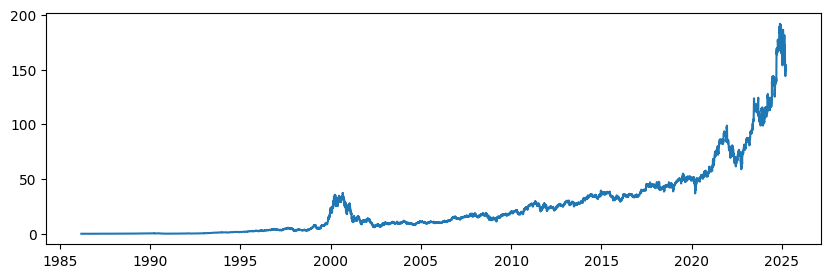

In [12]:
fig, ax = plt.subplots()
ax.plot(df["Date"], df["Close"])
fig.set_figwidth(10)
fig.set_figheight(3)
plt.show()

# 2. Last Year

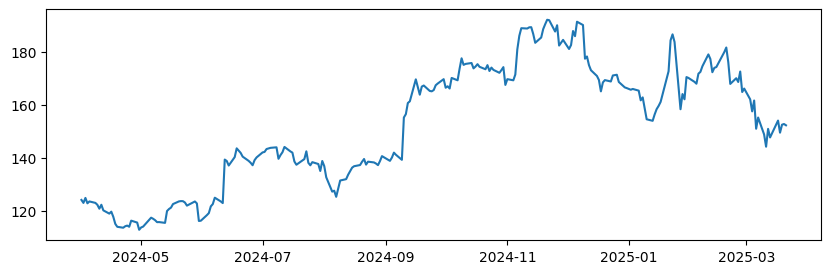

In [13]:
fig, ax = plt.subplots()

time = datetime.now()
time = datetime(time.year - 1, time.month, time.day).strftime("%Y-%m-%d")

df_last_year = df[df["Date"] > time]
ax.plot(df_last_year["Date"], df_last_year["Close"])
fig.set_figwidth(10)
fig.set_figheight(3)
plt.show()

# 3. Last Month

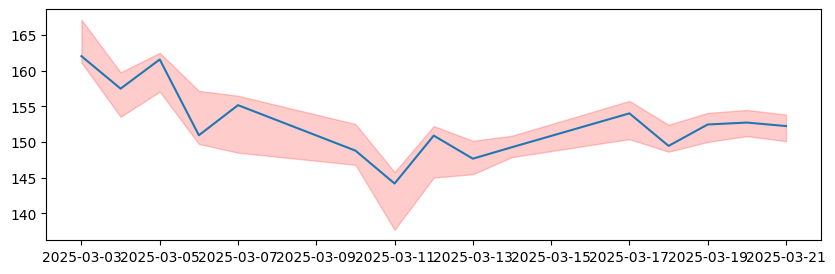

In [14]:
fig, ax = plt.subplots()

time = datetime.now()
time = datetime(time.year, time.month - 1, time.day).strftime("%Y-%m-%d")

df_last_year = df[df["Date"] > time]
ax.plot(df_last_year["Date"], df_last_year["Close"])
ax.fill_between(df_last_year["Date"], df_last_year["Low"], df_last_year["High"], alpha=0.2, color="red")
fig.set_figwidth(10)
fig.set_figheight(3)
plt.show()

# 4. Fourier Analysis

4918
4918
4918
4918
4918
4918
4918
4918
4918
4918


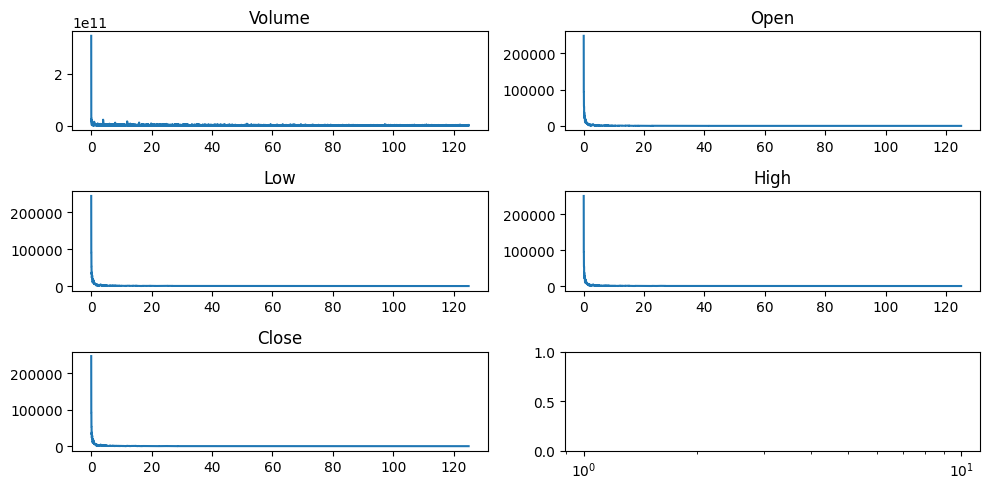

In [15]:
cols = 2
rows = int(df.drop(columns=["Date"]).shape[1] / cols) + 1

fig, axs = plt.subplots(rows, cols)

col_names = list(df.columns[1:])
for i in axs:
    for j in i:
        if len(col_names) < 1:
            continue

        col = col_names.pop()
        fft = tf.signal.rfft(df[col])

        fs = len(df[col]) / ( (df["Date"].max() - df["Date"].min()).total_seconds() / (3600 * 24 * 365.2524) )
        freqs = np.linspace(0, int(fs/2), len(fft))
        print(len(fft))
        print(len(freqs))

        j.step(freqs, np.abs(fft))
        j.set_title(col)
        plt.xscale("log")
plt.tight_layout()

# 4. <b>ML</b>

# 1. Preprocessing

## 1. Train Test Split

In [16]:
n = df.shape[0]
df = df.sort_values(by=["Date"])

train_df = df[0 : int(0.7*n)]
val_df = df[int(0.7*n) : int(0.9*n)]
test_df = df[int(0.9*n) : ]

train_df = train_df.drop(columns=["Date"])
val_df = val_df.drop(columns=["Date"])
test_df = test_df.drop(columns=["Date"])

column_indices = {name: i for i, name in enumerate(df.columns)}

## 2. Normalization

In [17]:
_window_size = 366
train_df = (train_df - train_df.rolling(window=_window_size).mean()) / train_df.rolling(window=_window_size).std()
val_df = (val_df - val_df.rolling(window=_window_size).mean()) / val_df.rolling(window=_window_size).std()
test_df = (test_df - test_df.rolling(window=_window_size).mean()) / test_df.rolling(window=_window_size).std()

train_df = train_df[_window_size:]
val_df = train_df[_window_size:]
test_df = train_df[_window_size:]

## 3. Make Dataset

In [18]:
window = WindowGenerator(input_width=DAYS_TO_LEARN, label_width=DAYS_TO_LEARN, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=["Close"])

print(window.train.element_spec)
print(window.val.element_spec)
print(window.test.element_spec)

for example_inputs, example_labels in window.train.take(1):
  print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
  print(f"Labels shape (batch, time, features): {example_labels.shape}")

for example_inputs, example_labels in window.val.take(1):
  print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
  print(f"Labels shape (batch, time, features): {example_labels.shape}")

for example_inputs, example_labels in window.test.take(1):
  print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
  print(f"Labels shape (batch, time, features): {example_labels.shape}")

(TensorSpec(shape=(None, 5, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5, 1), dtype=tf.float64, name=None))
(TensorSpec(shape=(None, 5, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5, 1), dtype=tf.float64, name=None))
(TensorSpec(shape=(None, 5, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5, 1), dtype=tf.float64, name=None))
Inputs shape (batch, time, features): (32, 5, 5)
Labels shape (batch, time, features): (32, 5, 1)
Inputs shape (batch, time, features): (32, 5, 5)
Labels shape (batch, time, features): (32, 5, 1)
Inputs shape (batch, time, features): (32, 5, 5)
Labels shape (batch, time, features): (32, 5, 1)


# 2. Training

## 1. Train

In [19]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [20]:
print('Input shape:', window.example[0].shape)
print('Input shape:', window.example[1].shape)
print('Output shape:', lstm_model(window.example[0]).shape)

Input shape: (32, 5, 5)
Input shape: (32, 5, 1)
Output shape: (32, 5, 1)


In [21]:
history = compile_and_fit(lstm_model, window)

val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate(window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(window.test, verbose=0, return_dict=True)

Epoch 1/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.8630 - mean_absolute_error: 0.6920 - val_loss: 0.1240 - val_mean_absolute_error: 0.2408
Epoch 2/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0959 - mean_absolute_error: 0.2093 - val_loss: 0.0562 - val_mean_absolute_error: 0.1618
Epoch 3/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0519 - mean_absolute_error: 0.1570 - val_loss: 0.0452 - val_mean_absolute_error: 0.1474
Epoch 4/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0433 - mean_absolute_error: 0.1452 - val_loss: 0.0416 - val_mean_absolute_error: 0.1418
Epoch 5/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0411 - mean_absolute_error: 0.1416 - val_loss: 0.0400 - val_mean_absolute_error: 0.1394
Epoch 6/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0394 - mean_absolute_error: 0.1390 - val_loss: 0.0391 - val_mean_absolute_error: 0.1379
Epoch 7/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0388 - mean_absolute_error: 0.1382 - 

## 2. Performance

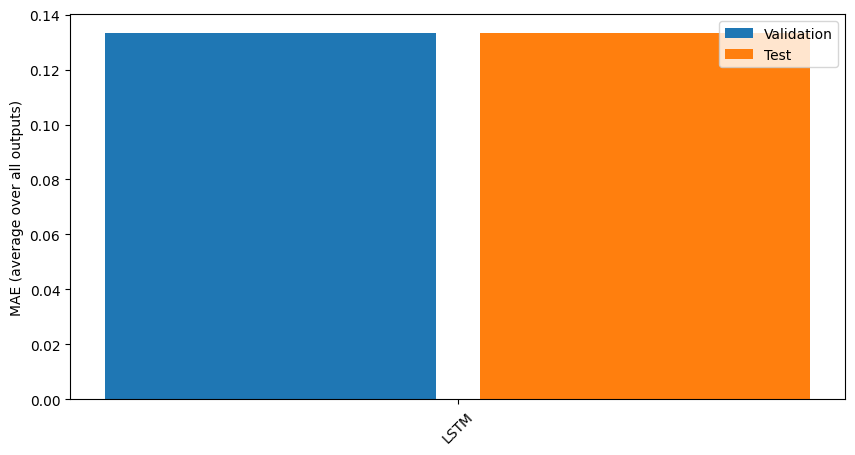

In [22]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [23]:
for name, value in performance.items():
  print(f'{name:15s}: {value[metric_name]:0.4f}')

LSTM           : 0.1335


Input: [0 1 2 3 4]
Label: [1 2 3 4 5]
Prediction: tf.Tensor([0.73665994 0.7413982  0.6490156  0.504871   0.49883336], shape=(5,), dtype=float32)
Input: [0 1 2 3 4]
Label: [1 2 3 4 5]
Prediction: tf.Tensor([2.1713755 2.089428  2.0650094 1.9992071 2.1041965], shape=(5,), dtype=float32)
Input: [0 1 2 3 4]
Label: [1 2 3 4 5]
Prediction: tf.Tensor([-0.43546665 -0.05823409 -0.00696988 -0.18156874 -0.04245823], shape=(5,), dtype=float32)


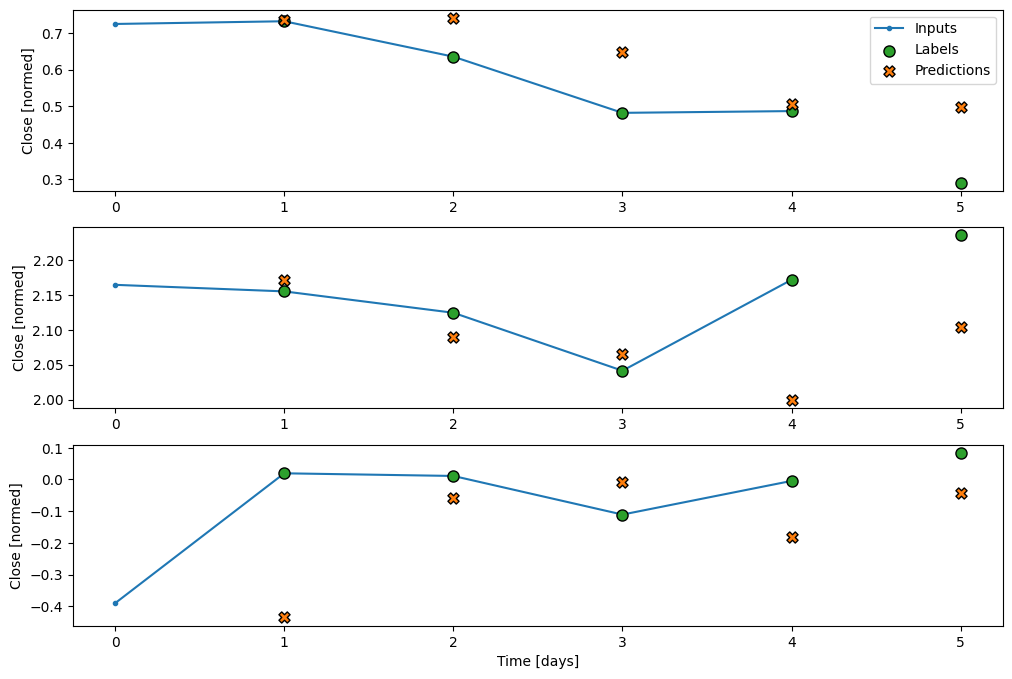

In [24]:
window.plot(lstm_model)

# 3. Exporting

In [25]:
path_save = "../../models/stock_prediction/"
lstm_model.save(path_save+"lstm.keras")